In [1]:
import sgml, sgutil, sgpp, dproc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from proc_v1 import p
from ml_v1 import X_cat, X_num, X_all, target, kf, ss, config
from ml_v1 import xgb_adapter, lgb_adapter, cb_adapter, lr_adapter

In [3]:
sc = sgutil.SGCache('img', 'result', 'model')
df_train = p.fit_transform('data/train.csv').assign(
    Calories_Log = lambda x: np.log(x['Calories'] + 1)
)
df_test = p.transform('data/test.csv')
len(df_train)

750000

# 1. Polynomial Feature Generation & Selection

- 1차, 1 / 1차, 2차, 1차 / 1차, 2차 / 1차, 1차 / 2차, 3차 속성을 만듭니다.
- 전체 속성으로 선형 모델을 학습 시키고, 회귀계수를 봅니다.
- 다중 공선성으로 인해 회귀계수가 커진 케이스가 확인 됐습니다. VIF를 측정하여 속성을 선별합니다.

In [4]:
from itertools import combinations, product

X_r = [i + '_r' for i in X_num]
X_o2 = [(i + '_2' if i == j else i + '_mul_'+ j, (i, j)) for i, j in product(X_num, X_num) if i <= j]
X_1d1 = [(i + '_div_' + j, (i, j)) for i, j in product(X_num, X_num) if i != j]
X_o2d1 = [
    (i + '_div_' + j, (i, j)) for (i, a), j in product(X_o2, X_num) if j not in a 
]
X_o1d2 = [
    (i + '_div_' + j, (i, j)) for i, (j, a) in product(X_num, X_o2) if i not in a 
]

X_o3 = [
    (
        i + '_3' if i == j and j == k else i + '_2_mul_' + k if i == j else i + '_2_mul_' + k if i == k  else j + '_2_mul_' + i if j == k else i + '_mul_' + j + '_mul_' + k,
        (i, j, k)
    )
    for i, j, k in product(X_num, X_num, X_num) if i <= j and i <= k and j <= k
]

In [5]:
var_list = [(1 / df_train[a]).rename(a + '_r') for a in X_num]
var_list.extend([(df_train[a].astype('float32') * df_train[b].astype('float32')).rename(i) for i, (a, b) in X_o2])
var_list.extend([(df_train[a].astype('float32') / df_train[b].astype('float32')).rename(i) for i, (a, b) in X_1d1])
var_list.extend([(df_train[a].astype('float32') * df_train[b].astype('float32') * df_train[c].astype('float32')).rename(i) for i, (a, b, c) in X_o3])

df_sel = dproc.join_and_assign(
    df_train,
    pd.concat(var_list, axis = 1)
)
df_sel = dproc.join_and_assign(
    df_sel,
    pd.concat([(df_sel[a] / df_sel[b]).rename(i) for i, (a, b) in X_o2d1 + X_o1d2], axis = 1)
)
df_sel.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,Calories_Log,Age_r,...,Body_Temp_div_Height_2,Body_Temp_div_Height_mul_Weight,Body_Temp_div_Weight_2,Body_Temp_div_Duration_mul_Height,Body_Temp_div_Duration_mul_Weight,Body_Temp_div_Duration_2,Body_Temp_div_Duration_mul_Heart_Rate,Body_Temp_div_Heart_Rate_mul_Height,Body_Temp_div_Heart_Rate_mul_Weight,Body_Temp_div_Heart_Rate_2
id,,,,,,,,,,,,,,,,,,,,,
0,True,36,189.0,82.0,26.0,101.0,41.000000,150.0,5.017280,0.027778,...,0.001148,0.002646,0.006098,0.008344,0.019231,0.060651,0.015613,0.002148,0.004950,0.004019
1,False,64,163.0,60.0,8.0,85.0,39.700001,34.0,3.555348,0.015625,...,0.001494,0.004059,0.011028,0.030445,0.082708,0.620313,0.058382,0.002865,0.007784,0.005495
2,False,51,161.0,64.0,7.0,84.0,39.799999,29.0,3.401197,0.019608,...,0.001535,0.003863,0.009717,0.035315,0.088839,0.812245,0.067687,0.002943,0.007403,0.005641
3,True,20,192.0,90.0,25.0,105.0,40.700001,140.0,4.948760,0.050000,...,0.001104,0.002355,0.005025,0.008479,0.018089,0.065120,0.015505,0.002019,0.004307,0.003692
4,False,38,166.0,61.0,25.0,102.0,40.599998,146.0,4.990433,0.026316,...,0.001473,0.004009,0.010911,0.009783,0.026623,0.064960,0.015922,0.002398,0.006525,0.003902


In [6]:
var_list = [(1 / df_test[a]).rename(a + '_r') for a in X_num]
var_list.extend([(df_test[a].astype('float32') * df_test[b].astype('float32')).rename(i) for i, (a, b) in X_o2])
var_list.extend([(df_test[a].astype('float32') / df_test[b].astype('float32')).rename(i) for i, (a, b) in X_1d1])
var_list.extend([(df_test[a].astype('float32') * df_test[b].astype('float32') * df_test[c].astype('float32')).rename(i) for i, (a, b, c) in X_o3])

df_sel_test = dproc.join_and_assign(
    df_test,
    pd.concat(var_list, axis = 1)
)
df_sel_test = dproc.join_and_assign(
    df_sel,
    pd.concat([(df_sel[a] / df_sel[b]).rename(i) for i, (a, b) in X_o2d1 + X_o1d2], axis = 1)
)
df_sel_test.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,Calories_Log,Age_r,...,Body_Temp_div_Height_2,Body_Temp_div_Height_mul_Weight,Body_Temp_div_Weight_2,Body_Temp_div_Duration_mul_Height,Body_Temp_div_Duration_mul_Weight,Body_Temp_div_Duration_2,Body_Temp_div_Duration_mul_Heart_Rate,Body_Temp_div_Heart_Rate_mul_Height,Body_Temp_div_Heart_Rate_mul_Weight,Body_Temp_div_Heart_Rate_2
id,,,,,,,,,,,,,,,,,,,,,
0,True,36,189.0,82.0,26.0,101.0,41.000000,150.0,5.017280,0.027778,...,0.001148,0.002646,0.006098,0.008344,0.019231,0.060651,0.015613,0.002148,0.004950,0.004019
1,False,64,163.0,60.0,8.0,85.0,39.700001,34.0,3.555348,0.015625,...,0.001494,0.004059,0.011028,0.030445,0.082708,0.620313,0.058382,0.002865,0.007784,0.005495
2,False,51,161.0,64.0,7.0,84.0,39.799999,29.0,3.401197,0.019608,...,0.001535,0.003863,0.009717,0.035315,0.088839,0.812245,0.067687,0.002943,0.007403,0.005641
3,True,20,192.0,90.0,25.0,105.0,40.700001,140.0,4.948760,0.050000,...,0.001104,0.002355,0.005025,0.008479,0.018089,0.065120,0.015505,0.002019,0.004307,0.003692
4,False,38,166.0,61.0,25.0,102.0,40.599998,146.0,4.990433,0.026316,...,0.001473,0.004009,0.010911,0.009783,0.026623,0.064960,0.015922,0.002398,0.006525,0.003902


In [7]:
X_sel = [i for i in df_sel.columns if i not in ('Calories', 'Calories_Log')]

In [8]:
from sklearn.preprocessing import StandardScaler 
df_sel[X_sel] = StandardScaler().fit_transform(df_sel[X_sel])

In [9]:
result = sgml.cv(df_sel, ss, {'X_num': X_sel}, config, lr_adapter, result_proc = [sgml.lr_learning_result])
rmse_all = result['valid_scores'][0]
rmse_all

Fold:   0%|          | 0/1 [00:00<?, ?it/s]

np.float64(0.06812648703363128)

In [10]:
result['model_result'][0]['coef'].sort_values()

Age_mul_Body_Temp      -2677.607575
Weight_div_Body_Temp   -2300.548247
Heart_Rate_2           -2002.387704
Age_div_Body_Temp      -1874.426193
Body_Temp_mul_Weight   -1743.892066
                           ...     
Height_mul_Weight       2120.462375
Duration_div_Height     2484.250041
Duration_mul_Height     2901.800484
Age                     3203.112368
Weight                  3328.888980
Length: 300, dtype: float64

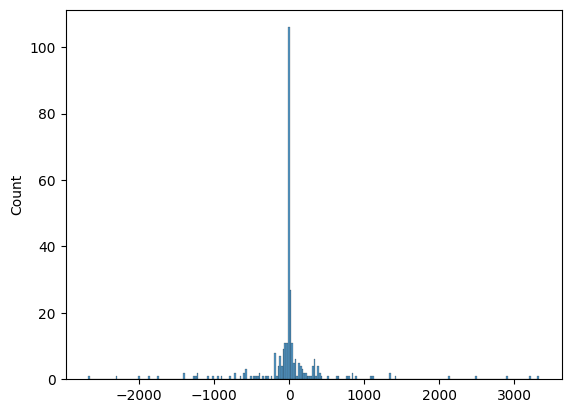

In [11]:
sns.histplot(result['model_result'][0]['coef'])
plt.show()

- 변수가 300개라 모든 변수를 가지고 순차적 선택을 하는 것에는 리소스에 무리가 있었습니다.

- 이를 보완 하기 위해, 차수가 낮은 것에서 시작하여 높은 것으로 그룹핑하여 추가를 해갑니다.

In [11]:
from cuml.linear_model import LinearRegression as cu_LinearRegression
lr_c_adapter = sgml.SklearnAdapter(cu_LinearRegression)

In [12]:
from tqdm.notebook import tqdm
import multiprocessing as mp

def get_rmse_c(X):
    return sgml.cv(df_sel, ss, {'model_params': {'copy_X': True}, 'X_num': X}, {**config, 'progress_callback': None}, lr_c_adapter)['valid_scores'][0]

def fs(X, X_ff):
    return pd.Series(
        {i: get_rmse_c(X + [i]) for i in X_ff if i not in X}
    ).sort_values()
def be(X, floated_list):
    if len(X) < 2: return pd.Series()
    return pd.Series(
        {i: get_rmse_c([j for j in X if j != i]) for i in X[:-1] if i not in floated_list}
    ).sort_values()

def step_fs(X_, X_selected, floated_list, rmse_list):
    while(True):
        s_rmse = fs(X_selected, X_)
        if len(s_rmse) == 0:
            break
        if rmse_list[-1] > s_rmse.iloc[0]:
            rmse_list.append(s_rmse.iloc[0])
            X_selected.append(s_rmse.index[0])
            print("Selected: {}, RMSE: {}".format(X_selected[-1], rmse_list[-1]))
        else:
            break
        while(True):
            s_rmse = be(X_selected, floated_list)
            if len(s_rmse) > 0 and rmse_list[-1] > s_rmse.iloc[0]:
                rmse_list.append(s_rmse.iloc[0])
                floated_list.add(s_rmse.index[0])
                X_selected = [i for i in X_selected if i != s_rmse.index[0]]
                print("Excluded: {}, RMSE: {}".format(s_rmse.index[0], rmse_list[-1]))
            else:
                break
    return X_selected, floated_list, rmse_list

In [13]:
def get_rmse(v):
    i, X = v[0], v[1]
    return i, sgml.cv(df_sel, ss, {'X_num': X}, {**config, 'progress_callback': None}, lr_adapter)['valid_scores'][0]

def fs_mp(X, X_ff):
    X_list = [(i, X + [i]) for i in X_ff if i not in X]
    with mp.Pool(mp.cpu_count()) as pool:
        results = pool.map(get_rmse, X_list)
    return pd.Series(
        {k: v for k, v in results}
    ).sort_values()

def be_mp(X, floated_list):
    if len(X) < 2: return pd.Series()
    X_list = [(i, [j for j in X if j != i]) for i in X[:-1] if i not in floated_list]
    with mp.Pool(mp.cpu_count()) as pool:
        results = pool.map(get_rmse, X_list)
    return pd.Series(
        {k: v for k, v in results}
    ).sort_values()

def step_fs_mp(X_, X_selected, floated_list, rmse_list):
    while(True):
        s_rmse = fs_mp(X_selected, X_)
        if len(s_rmse) == 0:
            break
        if rmse_list[-1] > s_rmse.iloc[0]:
            rmse_list.append(s_rmse.iloc[0])
            X_selected.append(s_rmse.index[0])
            print("Selected: {}, RMSE: {}".format(X_selected[-1], rmse_list[-1]))
        else:
            break
        while(True):
            s_rmse = be_mp(X_selected, floated_list)
            if len(s_rmse) > 0 and rmse_list[-1] > s_rmse.iloc[0]:
                rmse_list.append(s_rmse.iloc[0])
                floated_list.add(s_rmse.index[0])
                X_selected = [i for i in X_selected if i != s_rmse.index[0]]
                print("Excluded: {}, RMSE: {}".format(s_rmse.index[0], rmse_list[-1]))
            else:
                break
    return X_selected, floated_list, rmse_list

In [29]:
X_selected = list()
rmse_list = [np.inf]
X_ = X_num
X_selected, floated_list, rmse_list = sc.cache_result('fs_o1', lambda : step_fs(X_num, X_selected, set(), rmse_list), rerun = 0)
rmse_list[-1]

0.18064835569722082

In [30]:
X_selected, floated_list, rmse_list = sc.cache_result(
    'fs_r', lambda : step_fs(X_r, X_selected, set(), rmse_list), rerun = 0
)
rmse_list[-1]

0.11890502541192025

In [31]:
X_selected, floated_list, rmse_list = sc.cache_result(
    'fs_o2', lambda : step_fs([i[0] for i in X_o2], X_selected, set(), rmse_list), rerun = 0
)
rmse_list[-1]

0.08281917544819209

In [32]:
X_selected, floated_list, rmse_list = sc.cache_result(
    'fs_1d1', lambda : step_fs([i[0] for i in X_1d1], X_selected, set(), rmse_list), rerun = 0
)
rmse_list[-1]

0.07591978840844088

In [33]:
X_selected, floated_list, rmse_list = sc.cache_result(
    'fs_o2d1', lambda : step_fs_mp([i[0] for i in X_o2d1], X_selected, set(), rmse_list), rerun = 0
)
rmse_list[-1]

0.0718067288948422

In [34]:
X_selected, floated_list, rmse_list = sc.cache_result(
    'fs_o1d2', lambda : step_fs_mp([i[0] for i in X_o1d2], X_selected, set(), rmse_list), rerun = 0
)
rmse_list[-1]

0.07070597741714742

In [35]:
X_selected, floated_list, rmse_list = sc.cache_result(
    'fs_o3', lambda : step_fs_mp([i[0] for i in X_o3], X_selected, set(), rmse_list), rerun = 0
)
rmse_list[-1]

0.07054807770710889

In [36]:
result = sgml.cv(df_sel, ss, {'X_num': X_selected}, config, lr_adapter, result_proc = [sgml.lr_learning_result])
result['valid_scores']

Fold:   0%|          | 0/1 [00:00<?, ?it/s]

[0.07054807770711112]

In [21]:
len(X_selected), np.array(X_selected)

(98,
 array(['Body_Temp', 'Duration', 'Duration_2', 'Body_Temp_mul_Duration',
        'Body_Temp_mul_Weight', 'Weight_2', 'Age_mul_Height',
        'Body_Temp_div_Duration', 'Weight_div_Heart_Rate',
        'Age_div_Weight', 'Heart_Rate_div_Body_Temp',
        'Weight_div_Duration', 'Body_Temp_div_Weight', 'Height_div_Age',
        'Weight_2_div_Heart_Rate', 'Duration_2_div_Body_Temp',
        'Heart_Rate_2_div_Duration', 'Weight_2_div_Age',
        'Height_mul_Weight_div_Body_Temp', 'Height_mul_Weight_div_Age',
        'Age_mul_Weight_div_Height', 'Age_mul_Height_div_Weight',
        'Body_Temp_mul_Heart_Rate_div_Duration',
        'Heart_Rate_2_div_Body_Temp', 'Heart_Rate_2_div_Weight',
        'Weight_2_div_Duration', 'Duration_mul_Heart_Rate_div_Body_Temp',
        'Duration_2_div_Heart_Rate', 'Body_Temp_2_div_Weight',
        'Height_2_div_Body_Temp', 'Age_2_div_Heart_Rate',
        'Age_mul_Weight_div_Duration', 'Heart_Rate_mul_Weight_div_Age',
        'Age_mul_Weight_div_Heart_R

In [37]:
pd.Series(result['model_result'][0]['coef']).sort_values()

Body_Temp_mul_Duration            -628.440215
Height_mul_Weight_div_Body_Temp    -55.189597
Duration_div_Body_Temp_2           -46.878210
Duration_2_div_Body_Temp           -45.344002
Heart_Rate_div_Body_Temp           -42.269036
                                      ...    
Weight_div_Body_Temp_2              52.618924
Body_Temp_mul_Weight                76.852817
Duration_2                          86.418111
Body_Temp_2_mul_Duration           238.878689
Duration                           472.902968
Length: 98, dtype: float64

In [ ]:
from sklearn.linear_model import Lasso
result = sgml.cv(df_sel, ss, {'model_params': {'alpha': 1e-6, 'max_iter': 2000}, 'X_num': X_sel}, config, sgml.SklearnAdapter(Lasso), result_proc = [sgml.lr_learning_result])
result['valid_scores']

In [ ]:
sns.histplot(result['model_result'][0]['coef'])
plt.show()

In [40]:
from sklearn.linear_model import Ridge
result = sgml.cv(df_sel, ss, {'model_params': {'alpha': 1e-3}, 'X_num': X_sel}, config, sgml.SklearnAdapter(Ridge), result_proc = [sgml.lr_learning_result])
result['valid_scores']

Fold:   0%|          | 0/1 [00:00<?, ?it/s]

[0.068523406731391]

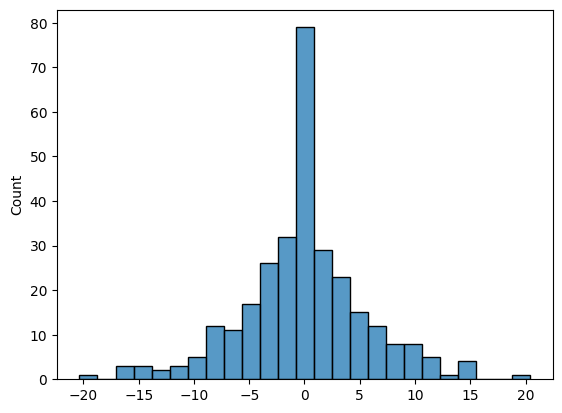

In [41]:
sns.histplot(result['model_result'][0]['coef'])
plt.show()

In [42]:
pd.Series(result['model_result'][0]['coef']).sort_values()

Heart_Rate                              -20.365835
Body_Temp_2_mul_Duration                -16.865307
Heart_Rate_2_mul_Duration               -16.786587
Heart_Rate_div_Body_Temp                -15.564463
Weight_2_mul_Body_Temp                  -14.918791
                                           ...    
Body_Temp_mul_Duration_mul_Heart_Rate    14.198431
Age_mul_Height_mul_Weight                14.302717
Body_Temp_div_Heart_Rate_2               14.497902
Heart_Rate_2_div_Body_Temp               15.153733
Heart_Rate_2_mul_Body_Temp               20.439106
Length: 300, dtype: float64

- Ridge로 회귀계수의 크기를 줄일 수 있지만 성능도 같이 줄어드니다.

- Backward Eliminations를 사용해봅니다.

In [ ]:
def be_mp2(X, floated_list):
    if len(X) < 2: return pd.Series()
    X_list = [(i, [j for j in X if j != i]) for i in X if i not in floated_list]
    results = {}
    for k, v in tqdm(X_list):
        results[k] = get_rmse_c(v)
    return pd.Series(results).sort_values()

el = list()
rmse_list = [get_rmse_c(X_sel)]
cnt = 0
while(True):
    s_rmse = sc.cache_result(
        'be_{}'.format(cnt), lambda : be_mp2([i for i in X_sel if i not in el], set())
    )
    cnt += 1
    if len(s_rmse) > 0 and rmse_list[-1] > s_rmse.iloc[0]:
        rmse_list.append(s_rmse.iloc[0])
        el.append(s_rmse.index[0])
        print("Excluded: {}, RMSE: {}".format(el[-1], rmse_list[-1]))
    else:
        break

- 성능의 개선 여지가 크지 않습니다.

- 공선성이 큰 속성을 제외해봅니다.

In [14]:
from sklearn.metrics import r2_score
import gc
def get_r2(X_var):
    r2_scores = list()
    for i in tqdm(X_var):
        X_ = [j for j in X_var if j != i]
        r2_scores.append(
            r2_score(
                df_sel[i], cu_LinearRegression(copy_X = True).fit(df_sel[X_], df_sel[i]).predict(df_sel[X_])
            )
        )
        gc.collect()
    return pd.Series(r2_scores, index = X_var).sort_values(ascending = False)

- 원래 변수들 간의 다중 공선성을 조사합니다.

In [15]:
get_r2(X_num)

  0%|          | 0/6 [00:00<?, ?it/s]

Weight        0.921672
Height        0.921273
Duration      0.882499
Body_Temp     0.816003
Heart_Rate    0.766673
Age           0.048410
dtype: float64

- Weight와 Height가 공선성이 강합니다.

In [16]:
get_r2([i for i in X_num if i != 'Weight'])

  0%|          | 0/5 [00:00<?, ?it/s]

Duration      0.882476
Body_Temp     0.815981
Heart_Rate    0.766543
Height        0.002123
Age           0.001859
dtype: float64

In [17]:
get_r2([i for i in X_num if i not in ['Weight', 'Duration']])

  0%|          | 0/4 [00:00<?, ?it/s]

Body_Temp     0.634442
Heart_Rate    0.633830
Height        0.001938
Age           0.001230
dtype: float64

In [52]:
import numpy as np
from numpy.linalg import inv

def r2_schur_complement(X):
    """
    X: centered data matrix of shape (n_samples, n_features)
    Returns: R^2 score for each variable treated as target,
             using Schur complement and Gram matrix inversion
    """
    n, p = X.shape

    # Step 1: Center the data (important for correct variance)
    Xc = X - X.mean(axis=0)

    # Step 2: Compute Gram matrix and its inverse
    G = Xc.T @ Xc
    G_inv = inv(G)

    r2s = np.zeros(p)

    for j in range(p):
        # Step 3: Extract alpha = (G_inv)_{jj}
        alpha = G_inv[j, j]

        # Step 4: Variance of x_j (centered)
        var_j = np.var(Xc[:, j], ddof=0) * n  # multiply by n because G = X.T @ X

        # Step 5: R² calculation using Schur complement identity
        r2 = 1 - (1 / (alpha * var_j))
        r2s[j] = r2

    return r2s

def r2_sc(X):
    return pd.Series(
        r2_schur_complement(df_sel[X].values), index = X
    ).sort_values(ascending = False)

In [54]:
r2_sc(X_num)

Weight        0.921672
Height        0.921273
Duration      0.882499
Body_Temp     0.816003
Heart_Rate    0.766673
Age           0.048410
dtype: float64

In [55]:
r2_sc([i for i in X_num if i != 'Weight'])

Duration      0.882476
Body_Temp     0.815981
Heart_Rate    0.766543
Height        0.002123
Age           0.001859
dtype: float64

- r2_schur_complement를 이용하여 변수를 포함 시켰을 때 공선성이 적은 변수를 골라 포함시켜갑니다.

In [173]:
def get_var_to_eliminate(X_tgt, threshold = 0.99):
    el = {}
    for i in range(len(X_tgt)):
        s_r2 = r2_sc([i for i in X_tgt if i not in el])
        if s_r2.iloc[0] > threshold:
            el[s_r2.index[0]] = s_r2.iloc[0]
        else:
            break
    return pd.Series(el)

In [137]:
X_tgt = X_num + X_r + ['Sex']
s_ex = get_var_to_eliminate(X_tgt, 0.99999)
ex = s_ex.index.tolist()
s_ex

Series([], dtype: object)

In [138]:
X_tgt = [i for i in X_tgt if i not in ex] + [i[0] for i in X_o2]
s_ex = get_var_to_eliminate(X_tgt, 0.99999)
ex.extend(s_ex.index.tolist())
s_ex

Body_Temp                 1.000000
Height                    0.999998
Heart_Rate                0.999995
Body_Temp_mul_Duration    0.999995
Body_Temp_mul_Height      0.999993
dtype: float64

In [139]:
X_tgt = [i for i in X_tgt if i not in ex] + [i[0] for i in X_1d1]
s_ex = get_var_to_eliminate(X_tgt, 0.99999)
ex.extend(s_ex.index.tolist())
s_ex

Weight                      1.000000
Age                         1.000000
Height_r                    1.000000
Heart_Rate_r                1.000000
Duration                    0.999999
Weight_div_Body_Temp        0.999999
Heart_Rate_mul_Height       0.999998
Weight_r                    0.999998
Height_mul_Weight           0.999997
Duration_div_Body_Temp      0.999995
Heart_Rate_div_Height       0.999994
Age_mul_Height              0.999993
Body_Temp_mul_Heart_Rate    0.999992
Body_Temp_mul_Weight        0.999992
Age_r                       0.999992
dtype: float64

In [140]:
X_tgt = [i for i in X_tgt if i not in ex] + [i[0] for i in X_o2d1]
s_ex = get_var_to_eliminate(X_tgt, 0.99999)
ex.extend(s_ex.index.tolist())
s_ex

Body_Temp_div_Duration                 1.000000
Body_Temp_2_div_Weight                 1.000000
Body_Temp_mul_Duration_div_Height      1.000000
Body_Temp_mul_Weight_div_Heart_Rate    1.000000
Age_div_Height                         1.000000
                                         ...   
Age_mul_Body_Temp_div_Weight           0.999994
Weight_div_Heart_Rate                  0.999994
Duration_mul_Height_div_Weight         0.999992
Heart_Rate_div_Age                     0.999992
Duration_mul_Weight_div_Height         0.999992
Length: 69, dtype: float64

In [141]:
X_tgt = [i for i in X_tgt if i not in ex] + [i[0] for i in X_o1d2]
s_ex = get_var_to_eliminate(X_tgt, 0.99999)
ex.extend(s_ex.index.tolist())
s_ex

Body_Temp_div_Heart_Rate               1.000000
Height_div_Body_Temp                   1.000000
Heart_Rate_div_Height_mul_Weight       1.000000
Weight_div_Body_Temp_mul_Heart_Rate    1.000000
Height_div_Age_mul_Body_Temp           1.000000
                                         ...   
Body_Temp_div_Weight_2                 0.999992
Body_Temp_div_Age_mul_Heart_Rate       0.999992
Duration_2_div_Height                  0.999992
Age_mul_Height_div_Weight              0.999991
Weight_2_div_Heart_Rate                0.999991
Length: 70, dtype: float64

In [142]:
X_tgt = [i for i in X_tgt if i not in ex] + [i[0] for i in X_o3]
s_ex = get_var_to_eliminate(X_tgt, 0.99999)
ex.extend(s_ex.index.tolist())
s_ex

Heart_Rate_2_mul_Body_Temp               1.000000
Height_2_mul_Body_Temp                   1.000000
Body_Temp_2                              1.000000
Body_Temp_mul_Heart_Rate_mul_Height      1.000000
Weight_2_mul_Height                      1.000000
Body_Temp_mul_Duration_mul_Heart_Rate    1.000000
Body_Temp_mul_Duration_mul_Height        1.000000
Height_2                                 1.000000
Body_Temp_mul_Height_mul_Weight          1.000000
Body_Temp_2_mul_Weight                   1.000000
Height_2_mul_Heart_Rate                  1.000000
Age_mul_Body_Temp_mul_Height             1.000000
Heart_Rate_2                             1.000000
Body_Temp_mul_Heart_Rate_mul_Weight      1.000000
Heart_Rate_mul_Height_mul_Weight         1.000000
Age_mul_Body_Temp_mul_Heart_Rate         1.000000
Body_Temp_2_mul_Duration                 1.000000
Duration_mul_Heart_Rate_mul_Height       1.000000
Age_mul_Duration                         1.000000
Duration_2                               1.000000


In [143]:
result = sgml.cv(df_sel, ss, {'X_num': [i for i in X_tgt if i not in ex]}, config, lr_adapter, result_proc = [sgml.lr_learning_result])
result['valid_scores']

Fold:   0%|          | 0/1 [00:00<?, ?it/s]

[np.float64(0.07046704019473402)]

In [144]:
pd.Series(result['model_result'][0]['coef']).sort_values()

Weight_2_mul_Duration                -1.498903
Age_mul_Heart_Rate_div_Weight        -1.444948
Heart_Rate_div_Weight_2              -1.223139
Duration_2_mul_Heart_Rate            -0.996936
Duration_div_Body_Temp_2             -0.782936
                                        ...   
Heart_Rate_2_mul_Age                  0.965442
Heart_Rate_2_div_Weight               1.380547
Duration_mul_Heart_Rate_mul_Weight    1.687289
Duration_mul_Weight_div_Heart_Rate    1.721354
Age_mul_Weight_div_Heart_Rate         1.872700
Length: 90, dtype: float64

In [193]:
s_exc = sc.cache_result(
    'exc_r2', lambda : get_var_to_eliminate(X_sel, 0.8)
)

In [196]:
result = sgml.cv(df_sel, ss, {'X_num': [i for i in X_sel if i not in s_exc.index[:50]]}, config, lr_adapter, result_proc = [sgml.lr_learning_result])
result['valid_scores']

Fold:   0%|          | 0/1 [00:00<?, ?it/s]

[np.float64(0.06822093720628665)]

In [194]:
result = sgml.cv(df_sel, ss, {'X_num': [i for i in X_sel if i not in s_exc.index[:100]]}, config, lr_adapter, result_proc = [sgml.lr_learning_result])
result['valid_scores']

Fold:   0%|          | 0/1 [00:00<?, ?it/s]

[np.float64(0.06878822252910614)]

In [195]:
result = sgml.cv(df_sel, ss, {'X_num': [i for i in X_sel if i not in s_exc.index[:200]]}, config, lr_adapter, result_proc = [sgml.lr_learning_result])
result['valid_scores']

Fold:   0%|          | 0/1 [00:00<?, ?it/s]

[np.float64(0.07019713835429388)]

In [197]:
result = sgml.cv(df_sel, ss, {'X_num': [i for i in X_sel if i not in s_exc.index[:250]]}, config, lr_adapter, result_proc = [sgml.lr_learning_result])
result['valid_scores']

Fold:   0%|          | 0/1 [00:00<?, ?it/s]

[np.float64(0.07401156122859469)]

In [200]:
result = sgml.cv(df_sel, ss, {'X_num': [i for i in X_sel if i not in s_exc.index[:270]]}, config, lr_adapter, result_proc = [sgml.lr_learning_result])
result['valid_scores']

Fold:   0%|          | 0/1 [00:00<?, ?it/s]

[np.float64(0.07777651286116685)]

In [198]:
result = sgml.cv(df_sel, ss, {'X_num': [i for i in X_sel if i not in s_exc.index[:290]]}, config, lr_adapter, result_proc = [sgml.lr_learning_result])
result['valid_scores']

Fold:   0%|          | 0/1 [00:00<?, ?it/s]

[np.float64(0.2554399056147664)]

In [191]:
result = sgml.cv(df_sel, ss, {'pca': {'X_num': X_sel, 'hparams': {'n_components': 0.9999}}}, config, lr_adapter, result_proc = [sgml.lr_learning_result])
result['valid_scores']

Fold:   0%|          | 0/1 [00:00<?, ?it/s]

[np.float64(0.07398964134988684)]

In [ ]:

import numpy as np
from numpy.linalg import inv

def r2_on_variable_addition(X_all, y, base_vars):
    """
    X_all: (n, p) full variable matrix
    y: (n,) target
    base_vars: list of column indices to use as initial predictors
    Returns: dict {added_var: new R²}
    """
    n, p = X_all.shape
    Xc = X_all - X_all.mean(axis=0)
    yc = y - y.mean()

    X_base = Xc[:, base_vars]
    G = X_base.T @ X_base
    b = X_base.T @ yc
    G_inv = inv(G)
    total_var = np.sum(yc ** 2)

    r2s = {}
    base_set = set(base_vars)
    for j in range(p):
        if j in base_set:
            continue

        xj = Xc[:, j:j+1]  # shape (n,1)
        z = X_base.T @ xj   # shape (p-1,1)
        alpha = float(xj.T @ xj)
        beta = float(xj.T @ yc)

        # s = Schur complement
        s = alpha - float(z.T @ G_inv @ z)
        if s <= 1e-10:
            r2s[j] = np.nan  # ill-conditioned
            continue

        # Update beta: [beta_base; beta_j]
        top = G_inv @ (b + z * beta / s)
        beta_j = (beta - z.T @ top).item() / s
        beta_full = np.vstack([top, beta_j])

        X_full = np.hstack([X_base, xj])
        y_pred = X_full @ beta_full
        ss_res = np.sum((yc - y_pred.flatten()) ** 2)
        r2 = 1 - ss_res / total_var
        r2s[j] = r2

    return r2s

In [ ]:
import numpy as np
from numpy.linalg import inv

def r2_drop_fast_with_schur(X, y):
    """
    X: (n_samples, n_features) centered input
    y: (n_samples,) centered target
    Returns: R² values for models where each input variable is dropped,
             using Schur complement and inverse update
    """
    n, p = X.shape
    Xc = X - X.mean(axis=0)
    yc = y - y.mean()

    G = Xc.T @ Xc
    G_inv = inv(G)
    b = Xc.T @ yc
    total_var = np.sum(yc ** 2)

    r2s = np.zeros(p)

    for j in range(p):
        idx = np.arange(p) != j

        # Extract M, alpha, v from full G_inv
        M = G_inv[np.ix_(idx, idx)]             # (p-1)x(p-1)
        v = G_inv[idx, j].reshape(-1, 1)         # (p-1)x1
        alpha = G_inv[j, j]                      # scalar

        # Schur-complement-based inverse of G_sub
        G_sub_inv = M - (v @ v.T) / alpha

        # b_sub for beta
        b_sub = b[idx].reshape(-1, 1)            # (p-1)x1
        beta_sub = G_sub_inv @ b_sub             # (p-1)x1

        # Predict y using X_{-j}
        y_pred = Xc[:, idx] @ beta_sub
        ss_res = np.sum((yc - y_pred.flatten()) ** 2)
        r2s[j] = 1 - ss_res / total_var

    return r2s